# Evaluation pipeline

## 0 Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg, get_discriminative_test_performance
from data_evaluation.visual.visual_evaluation import visual_evaluation
from predictive_evaluation import predictive_evaluation

In [3]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic" / "usable"

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [4]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp', 'autoencoder'
syn_data_type = 'timewarp'

In [5]:
# Load real time series
data_real_df = pd.read_csv(REAL_DATA_FOLDER/'metro_interstate_traffic_volume_label_encoded_no_categorical.csv')
data_real_numpy = dc(data_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_lstm_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_gru_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'autoencoder':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28478_12_5_autoencoder_unscaled.csv', shape=(28478, 12, 5))

elif syn_data_type == 'jitter':
    jitter_factor = 0.1
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_jittered_{str(jitter_factor).replace(".", "")}.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

# Loot at real and syn data
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_real_df.columns)

print('\n\n syn data:\n')
print(df.describe())

print('\n\nreal data:\n')
print(data_real_df.describe())



 syn data:

       traffic_volume          temp       rain_1h       snow_1h    clouds_all
count    28511.000000  28511.000000  28511.000000  28511.000000  28511.000000
mean      3299.968450    283.470261      0.074592      0.000267     42.295143
std       1933.184262     12.065327      0.714961      0.008246     37.772630
min          0.091959    243.521770      0.000000      0.000000      0.000000
25%       1398.199030    274.298446      0.000000      0.000000      1.000000
50%       3557.701883    285.584000      0.000000      0.000000     39.347654
75%       4922.942623    293.171000      0.000000      0.000000     88.303943
max       7131.318552    309.429771     41.664261      0.510000    100.000000


real data:

       traffic_volume          temp       rain_1h       snow_1h    clouds_all
count     28511.00000  28511.000000  28511.000000  28511.000000  28511.000000
mean       3313.74238    282.688768      0.061611      0.000250     42.122795
std        1971.53206     12.367361 

## 2 Predictive Evaluation

### Set Hyperparameters and Features

In [6]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 4,
    "num_layers": 1,
    "bidirectional": True,
    "num_evaluation_runs": 10,
    "num_epochs": 200,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [7]:
# evaluate predictive performance
predictive_results = predictive_evaluation(data_real_numpy, data_syn_numpy, hyperparameters, include_baseline=True, verbose=True)

# save results
bidirectionality = "bi" if hyperparameters["bidirectional"] else 'no_bi'
predictive_results.to_csv(DATA_FOLDER / f"results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}_{bidirectionality}.csv", index=False)

# split in mse and mae results
mse_results = predictive_results.loc[predictive_results['Metric'] == 'MSE']
mae_results = predictive_results.loc[predictive_results['Metric'] == 'MAE']

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  4
num_layers :  1
bidirectional :  True
num_evaluation_runs :  10
num_epochs :  200
device :  cpu
Synthetic Data is sequential: False
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.16356404960155488
Training Loss: 0.11791826590895653
Training Loss: 0.0930770741775632
Validation Loss: 0.07376920645324032
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07278344415128231
Training Loss: 0.06760959178209305
Training Loss: 0.06572964731603861
Validation Loss: 0.06035171089212546
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06315679116174579
Training Loss: 0.06158516261726618
Training Loss: 0.0604852687753737
Validation Loss: 0.05553730418173115
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.058031433206051586
Training Loss: 0.0564726185426116
Training Loss: 0.05502623919397592
Validation Loss: 0.04976148840584112
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.05198590019717812
Training Loss: 0.050168855022639035
Training Loss:

c:\Users\fanny\Documents\ArnesShit\time_series_data_augmentation\data_evaluation\predictive\predictive_evaluation.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
 10%|█         | 1/10 [03:27<31:08, 207.65s/it]

Epoch: 1
Training Loss: 0.1583011532574892
Training Loss: 0.1251966630294919
Training Loss: 0.10208195379003883
Validation Loss: 0.0759114520519637
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07647400125861167
Training Loss: 0.06941117335110902
Training Loss: 0.0662662960216403
Validation Loss: 0.05902656577946095
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06153253445401788
Training Loss: 0.059261093698441986
Training Loss: 0.05687672033905983
Validation Loss: 0.05057214953926172
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05218515352346003
Training Loss: 0.050076246233657
Training Loss: 0.04741249815560877
Validation Loss: 0.04150502616016383
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.04250325375236571
Training Loss: 0.040618915781378745
Training Loss: 0.

 20%|██        | 2/10 [06:54<27:37, 207.18s/it]

Epoch: 1
Training Loss: 0.10839949861168861
Training Loss: 0.08884037058800459
Training Loss: 0.08165888143703341
Validation Loss: 0.07272992718420672
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07369550917297601
Training Loss: 0.07026312161237001
Training Loss: 0.06828055512160063
Validation Loss: 0.06163546279742477
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06292957222089171
Training Loss: 0.05982377965003252
Training Loss: 0.05733102699741721
Validation Loss: 0.050576768438802676
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05180625477805734
Training Loss: 0.048711511762812736
Training Loss: 0.04572227369062602
Validation Loss: 0.03911110668788465
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.040156705044209956
Training Loss: 0.03746006730943918
Training L

 30%|███       | 3/10 [10:21<24:08, 206.90s/it]

Validation Loss: 0.0030615618373947533
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5548192612826824
Training Loss: 0.4538154189288616
Training Loss: 0.3726331006735563
Validation Loss: 0.27485843002796173
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.23542774137109518
Training Loss: 0.15677558820694684
Training Loss: 0.10488349709659815
Validation Loss: 0.06585245864110047
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06716355921700597
Training Loss: 0.06086020313203335
Training Loss: 0.05797160070389509
Validation Loss: 0.05307081684972463
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05504037672653794
Training Loss: 0.05398005042225122
Training Loss: 0.05178896651603281
Validation Loss: 0.04748258963645844
Validation Accuracy: 0.0
*******************************

 40%|████      | 4/10 [13:45<20:36, 206.11s/it]

Training Loss: 0.006125311107025482
Validation Loss: 0.003109052267155788
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5368938940763474
Training Loss: 0.4050438951700926
Training Loss: 0.2938531631976366
Validation Loss: 0.16777303773030805
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.14279031090438365
Training Loss: 0.08994586810469628
Training Loss: 0.0685381823219359
Validation Loss: 0.058269427105616986
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05970649963244796
Training Loss: 0.05905788464471698
Training Loss: 0.05771952027454972
Validation Loss: 0.05510459944940685
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05460166754201055
Training Loss: 0.05403636272996664
Training Loss: 0.05234083712100983
Validation Loss: 0.04986825083078963
Validation Accuracy: 

 50%|█████     | 5/10 [17:10<17:08, 205.62s/it]

Validation Loss: 0.0025282779125120032
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5228372783958912
Training Loss: 0.4148260417580605
Training Loss: 0.32563879929482936
Validation Loss: 0.23658035427666782
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.1956882069259882
Training Loss: 0.1338166533783078
Training Loss: 0.09279951483011245
Validation Loss: 0.061206144060981404
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.057128015141934156
Training Loss: 0.04989870982244611
Training Loss: 0.046540599251165986
Validation Loss: 0.040758801477678706
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.043054770678281784
Training Loss: 0.0416535463090986
Training Loss: 0.03872377648949623
Validation Loss: 0.032959717692116676
Validation Accuracy: 0.0
***************************

 60%|██████    | 6/10 [20:35<13:41, 205.45s/it]

Training Loss: 0.006700249961577356
Validation Loss: 0.0035740225131131627
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5441212683916092
Training Loss: 0.4199144119024277
Training Loss: 0.30742365546524525
Validation Loss: 0.16852028165640456
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.14921418219804763
Training Loss: 0.09297890612855554
Training Loss: 0.06759082488715648
Validation Loss: 0.05107325403375572
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05234296740964055
Training Loss: 0.050604946296662096
Training Loss: 0.04919361537322402
Validation Loss: 0.047058958518371156
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04511154565960169
Training Loss: 0.04417287334799767
Training Loss: 0.042087010834366084
Validation Loss: 0.03958883155346586
Validation Accur

 70%|███████   | 7/10 [24:00<10:15, 205.21s/it]

Training Loss: 0.005498184132156894
Validation Loss: 0.002594998213619496
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.18486561737954615
Training Loss: 0.12700491454452276
Training Loss: 0.09336452035233378
Validation Loss: 0.071770807330528
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0668552266433835
Training Loss: 0.061618268992751836
Training Loss: 0.06016616640612483
Validation Loss: 0.055897335281197946
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05658294150605798
Training Loss: 0.05426382306031883
Training Loss: 0.052184926094487306
Validation Loss: 0.04707868956029415
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04689210135489702
Training Loss: 0.04381046013906598
Training Loss: 0.0405768514610827
Validation Loss: 0.034883367672060316
Validation Accurac

 80%|████████  | 8/10 [27:25<06:50, 205.06s/it]

Training Loss: 0.005759271210408769
Validation Loss: 0.0028201040898167182
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.11232005413621664
Training Loss: 0.08758618043735623
Training Loss: 0.07547678032889962
Validation Loss: 0.06422580753484469
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0664778776653111
Training Loss: 0.06451383735984564
Training Loss: 0.06324747920036317
Validation Loss: 0.05818397455503432
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.060777401085942984
Training Loss: 0.059197534043341875
Training Loss: 0.05720915671437979
Validation Loss: 0.05170649532856566
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.053659900277853015
Training Loss: 0.05158673951402307
Training Loss: 0.0486476234998554
Validation Loss: 0.042841318304116804
Validation Accu

 90%|█████████ | 9/10 [30:50<03:25, 205.07s/it]

Training Loss: 0.0058411222312133755
Validation Loss: 0.0028884238229928477
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.18783397395163776
Training Loss: 0.12589052122086286
Training Loss: 0.09072424726560711
Validation Loss: 0.06204957694987233
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06368085389956832
Training Loss: 0.058679582364857194
Training Loss: 0.055967514552175995
Validation Loss: 0.05009444606270683
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05256711399182677
Training Loss: 0.05134981200098991
Training Loss: 0.04875052963383496
Validation Loss: 0.04343056722722027
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04469487212598324
Training Loss: 0.04353845498524606
Training Loss: 0.04039647378958762
Validation Loss: 0.03492369331168325
Validation Acc

100%|██████████| 10/10 [34:15<00:00, 205.51s/it]


Validation Loss: 0.0030639922505328325
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)
Shape of the data after splitting into sequences: (28500, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.0762528096139431
Training Loss: 0.07415843024849891
Training Loss: 0.0718848935328424
Validation Loss: 0.07087248197516029
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06814275478944182
Training Loss: 0.06588919954374432
Training Loss: 0.0628412220813334
Validation Loss: 0.06050111910098054
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.057790092509239915
Training Loss: 0.05472590681165457
Training Loss: 0.05112023008987308
Validation Loss: 0.048365079065303455
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04584349756129086
Training Loss: 0.043032163875177505
Training Loss: 0.03967379538342357
Validation Loss: 0.03690735569872548
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.03472800916060805
Training Loss: 0.032766831642948094
Training Los

 10%|█         | 1/10 [03:26<30:59, 206.57s/it]

Validation Loss: 0.003948260525769941
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.08651368174701929
Training Loss: 0.07194882493466138
Training Loss: 0.06494210923090576
Validation Loss: 0.061397552950663514
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05770734326913953
Training Loss: 0.05495646914467216
Training Loss: 0.05228116437792778
Validation Loss: 0.05000633044231139
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04662077285349369
Training Loss: 0.04434019354172051
Training Loss: 0.04185622123070061
Validation Loss: 0.03896262471595507
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03594406422227621
Training Loss: 0.03384049870073795
Training Loss: 0.031271502794697884
Validation Loss: 0.027592090366596586
Validation Accuracy: 0.0
**************************

 20%|██        | 2/10 [06:56<27:46, 208.29s/it]

Validation Loss: 0.0033518238348907298
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.10382066588848829
Training Loss: 0.08293663155287505
Training Loss: 0.07383953232318163
Validation Loss: 0.07106847692741437
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0678276763483882
Training Loss: 0.066456453576684
Training Loss: 0.06529856342822313
Validation Loss: 0.06456329037299317
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0614461075514555
Training Loss: 0.059243164714425804
Training Loss: 0.056995768435299396
Validation Loss: 0.05458006183250567
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.051261434815824035
Training Loss: 0.048148061195388434
Training Loss: 0.0449816713295877
Validation Loss: 0.04130139681144377
Validation Accuracy: 0.0
*****************************

 30%|███       | 3/10 [10:25<24:20, 208.62s/it]

Validation Loss: 0.003019254090881833
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.2629644089192152
Training Loss: 0.1989934278279543
Training Loss: 0.14751470774412156
Validation Loss: 0.10520844086167518
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08886438073590398
Training Loss: 0.07399251824244857
Training Loss: 0.06777005914598704
Validation Loss: 0.06449631704122163
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.061783803422003986
Training Loss: 0.0591765371337533
Training Loss: 0.05711590343154967
Validation Loss: 0.054124724140830256
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.051574233919382095
Training Loss: 0.04864682924933732
Training Loss: 0.04618702841922641
Validation Loss: 0.04233836222523719
Validation Accuracy: 0.0
*****************************

 40%|████      | 4/10 [13:54<20:53, 208.98s/it]

Validation Loss: 0.0035244632064982246
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.15395826213061808
Training Loss: 0.11369446879252791
Training Loss: 0.08998745264485479
Validation Loss: 0.07777327525146892
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07385679271072149
Training Loss: 0.0719034051336348
Training Loss: 0.0709164671972394
Validation Loss: 0.07024926665040214
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06718028215691448
Training Loss: 0.06564837206155062
Training Loss: 0.06444985892623663
Validation Loss: 0.06336566048224321
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06002698335796595
Training Loss: 0.05815523335710168
Training Loss: 0.056489142645150425
Validation Loss: 0.05469001516741648
Validation Accuracy: 0.0
*****************************

 50%|█████     | 5/10 [17:24<17:26, 209.20s/it]

Validation Loss: 0.003548751157457323
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.1372464245557785
Training Loss: 0.1032153289206326
Training Loss: 0.08176951456815004
Validation Loss: 0.06952918314615662
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06369084030389786
Training Loss: 0.0597489769756794
Training Loss: 0.05659532304853201
Validation Loss: 0.053786832169535455
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04923572960309684
Training Loss: 0.04547320436686277
Training Loss: 0.04201118532568216
Validation Loss: 0.03870044475986382
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03475730186328292
Training Loss: 0.0324728170922026
Training Loss: 0.030087928078137337
Validation Loss: 0.027628050913008746
Validation Accuracy: 0.0
******************************

 60%|██████    | 6/10 [20:53<13:57, 209.28s/it]

Validation Loss: 0.0028261761687920963
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5154098466038703
Training Loss: 0.43363903686404226
Training Loss: 0.339044976234436
Validation Loss: 0.22689524937546654
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.17792908664792775
Training Loss: 0.11706793025135993
Training Loss: 0.08654069794341922
Validation Loss: 0.07410323287077834
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06984960000962019
Training Loss: 0.06845189262181521
Training Loss: 0.06792561849579215
Validation Loss: 0.06827476526495446
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06597111359238625
Training Loss: 0.06530306283384561
Training Loss: 0.06477711260318757
Validation Loss: 0.06486397253328495
Validation Accuracy: 0.0
*******************************

 70%|███████   | 7/10 [24:22<10:27, 209.23s/it]

Validation Loss: 0.003882249827716458
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.2284257760643959
Training Loss: 0.1833690009638667
Training Loss: 0.13855758048593997
Validation Loss: 0.09603228436762028
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08020601630210876
Training Loss: 0.06692513888701797
Training Loss: 0.06242634888738394
Validation Loss: 0.061312156363149704
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.059288966935127974
Training Loss: 0.058313791770488024
Training Loss: 0.05719414813444018
Validation Loss: 0.05653681991140494
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.054508141987025735
Training Loss: 0.05330164389684797
Training Loss: 0.05179394830018282
Validation Loss: 0.05053386397743493
Validation Accuracy: 0.0
***************************

 80%|████████  | 8/10 [27:51<06:58, 209.14s/it]

Validation Loss: 0.0028023201562830486
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07701804490759968
Training Loss: 0.06698856849223375
Training Loss: 0.06255834752693773
Validation Loss: 0.06057102017606912
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.057761295158416034
Training Loss: 0.05515991572290659
Training Loss: 0.05162403800524771
Validation Loss: 0.0480634518742059
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.044943293081596496
Training Loss: 0.04133239504881203
Training Loss: 0.037154224663972855
Validation Loss: 0.03343506700495321
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.031128086410462857
Training Loss: 0.028985157259739935
Training Loss: 0.026267596008256077
Validation Loss: 0.023506812405971328
Validation Accuracy: 0.0
**********************

 90%|█████████ | 9/10 [31:20<03:29, 209.18s/it]

Validation Loss: 0.003926964689260662
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.23635491617023946
Training Loss: 0.18011668197810649
Training Loss: 0.13378145154565574
Validation Loss: 0.09515253912783071
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07829450322315097
Training Loss: 0.0630861720070243
Training Loss: 0.05655861735343933
Validation Loss: 0.05390147816682799
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05288561233319342
Training Loss: 0.05165079396218061
Training Loss: 0.05027166717685759
Validation Loss: 0.04856400317355488
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.047679076911881564
Training Loss: 0.0461440435051918
Training Loss: 0.044284603418782355
Validation Loss: 0.04181677002585336
Validation Accuracy: 0.0
*****************************

100%|██████████| 10/10 [34:50<00:00, 209.06s/it]


Validation Loss: 0.0035195559681147296
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)
Shape of the data after splitting into sequences: (28500, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.33563279151916503
Training Loss: 0.24180472224950791
Training Loss: 0.17050122752785682
Validation Loss: 0.11775131444080492
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.09134437264874577
Training Loss: 0.06530407648533583
Training Loss: 0.05898112816736102
Validation Loss: 0.06709461786857482
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.057496819701045754
Training Loss: 0.05464989146217704
Training Loss: 0.05122443807311356
Validation Loss: 0.06035053792796778
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04915817112661898
Training Loss: 0.045904551232233644
Training Loss: 0.042056720219552514
Validation Loss: 0.05254565407469701
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.03907963316887617
Training Loss: 0.03548635576851666
Training L

 10%|█         | 1/10 [01:10<10:37, 70.80s/it]

Validation Loss: 0.015981109532935734
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 68
Early stopping after 68 epochs
Epoch: 1
Training Loss: 0.5603973086178303
Training Loss: 0.38743603065609933
Training Loss: 0.24075033769011497
Validation Loss: 0.14013239548782283
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.1033786103501916
Training Loss: 0.06485965602099895
Training Loss: 0.05250861642882228
Validation Loss: 0.06300518714058935
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04973911435343325
Training Loss: 0.04690767495892942
Training Loss: 0.0429624349810183
Validation Loss: 0.057246100659785644
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04099810482002795
Training Loss: 0.03810692798346281
Training Loss: 0.03422102740034461
Validation Loss: 0.051097239587414134
Validation Accuracy: 0.0


 20%|██        | 2/10 [02:33<10:20, 77.56s/it]

Validation Loss: 0.016333733813502314
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 79
Early stopping after 79 epochs
Epoch: 1
Training Loss: 0.4871057167649269
Training Loss: 0.36594637542963027
Training Loss: 0.26639449641108515
Validation Loss: 0.17659512258480103
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.12878999419510365
Training Loss: 0.07173186691477895
Training Loss: 0.057127338722348216
Validation Loss: 0.06703204429300313
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05334266395308077
Training Loss: 0.048974869027733806
Training Loss: 0.0456453962624073
Validation Loss: 0.057574522691998586
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04338360077701509
Training Loss: 0.03978803431615233
Training Loss: 0.03647812377661466
Validation Loss: 0.049663809640856274
Validation Accuracy: 0

 30%|███       | 3/10 [03:41<08:34, 73.55s/it]

Validation Loss: 0.016508377907965124
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 66
Early stopping after 66 epochs
Epoch: 1
Training Loss: 0.5506631666421891
Training Loss: 0.41747450560331345
Training Loss: 0.2891980154812336
Validation Loss: 0.17096071916349817
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.1128405905328691
Training Loss: 0.06485782142728568
Training Loss: 0.05342306721955538
Validation Loss: 0.06693834476591495
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.051970511022955176
Training Loss: 0.0494470245577395
Training Loss: 0.045698505360633135
Validation Loss: 0.06251079227063763
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04483721544034779
Training Loss: 0.04213066510856152
Training Loss: 0.03842026797123253
Validation Loss: 0.05716137893581658
Validation Accuracy: 0.0
*

 40%|████      | 4/10 [06:24<10:52, 108.77s/it]

Validation Loss: 0.016346953573814604
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 156
Early stopping after 156 epochs
Epoch: 1
Training Loss: 0.16432576928287745
Training Loss: 0.11343899441882968
Training Loss: 0.08233821500092744
Validation Loss: 0.07254779093972083
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06519515523687006
Training Loss: 0.06188300643116236
Training Loss: 0.05839577393606305
Validation Loss: 0.06454290617048071
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05739967694506049
Training Loss: 0.05517559277825058
Training Loss: 0.05123785689473152
Validation Loss: 0.05892600043770972
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.049180102348327634
Training Loss: 0.04621029610745609
Training Loss: 0.04187866508029401
Validation Loss: 0.051399486871917595
Validation Accuracy:

 50%|█████     | 5/10 [07:52<08:25, 101.10s/it]

Epoch: 1
Training Loss: 0.3773073135316372
Training Loss: 0.27564119510352614
Training Loss: 0.20541233725845814
Validation Loss: 0.15129611871383164
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.12274991430342197
Training Loss: 0.07792410142719745
Training Loss: 0.05732045892626047
Validation Loss: 0.06076344489800126
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.049409868363291025
Training Loss: 0.04607091651298106
Training Loss: 0.04354707703925669
Validation Loss: 0.05518350411164627
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04230668161064386
Training Loss: 0.03939515635371208
Training Loss: 0.03651700625196099
Validation Loss: 0.04982388675673289
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.03456602991558611
Training Loss: 0.03140555031131953
Training Loss

 60%|██████    | 6/10 [09:08<06:10, 92.64s/it] 

Validation Loss: 0.015851301823878724
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 73
Early stopping after 73 epochs
Epoch: 1
Training Loss: 0.7292816430330277
Training Loss: 0.5672819857299328
Training Loss: 0.4239041029661894
Validation Loss: 0.28724234207962335
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.21624394431710242
Training Loss: 0.11199983771890402
Training Loss: 0.06763674112036824
Validation Loss: 0.07195387851823581
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05305002113804221
Training Loss: 0.048039675997570155
Training Loss: 0.04499694937840104
Validation Loss: 0.06214938756455196
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04343404522165656
Training Loss: 0.03966185302473604
Training Loss: 0.036600962076336147
Validation Loss: 0.054959166815943934
Validation Accuracy: 0.0

 70%|███████   | 7/10 [10:13<04:10, 83.50s/it]

Validation Loss: 0.016695196871132998
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 62
Early stopping after 62 epochs
Epoch: 1
Training Loss: 0.34058753587305546
Training Loss: 0.21668857909739017
Training Loss: 0.12511736266314982
Validation Loss: 0.08143067456195864
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06280338931828737
Training Loss: 0.052377994386479255
Training Loss: 0.04885593711398542
Validation Loss: 0.05842982060956151
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04756446707993746
Training Loss: 0.044896248588338496
Training Loss: 0.041411368325352665
Validation Loss: 0.052524265958770605
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03916967548429966
Training Loss: 0.03606200598180294
Training Loss: 0.03252909348346293
Validation Loss: 0.04590857227782855
Validation Accuracy:

 80%|████████  | 8/10 [11:07<02:28, 74.15s/it]

Validation Loss: 0.01652888131715106
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 52
Early stopping after 52 epochs
Epoch: 1
Training Loss: 0.11116851679980755
Training Loss: 0.08721277754753828
Training Loss: 0.07606401707977056
Validation Loss: 0.0745028866810745
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07130225764587522
Training Loss: 0.06815222572535276
Training Loss: 0.06386476010084152
Validation Loss: 0.0668473770276884
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06185092430561781
Training Loss: 0.05898643884807825
Training Loss: 0.05451818026602268
Validation Loss: 0.05911879272859418
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05129453219473362
Training Loss: 0.047456677863374354
Training Loss: 0.04249600954353809
Validation Loss: 0.04961300234237079
Validation Accuracy: 0.0
*

 90%|█████████ | 9/10 [12:55<01:24, 84.81s/it]

Validation Loss: 0.016463742146707986
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 104
Early stopping after 104 epochs
Epoch: 1
Training Loss: 0.07539870679378509
Training Loss: 0.069364838860929
Training Loss: 0.0643068665266037
Validation Loss: 0.06762443535197317
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.060618198774755
Training Loss: 0.05670572002418339
Training Loss: 0.05106452191248536
Validation Loss: 0.056657328971483734
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.045759299322962764
Training Loss: 0.04112690822221339
Training Loss: 0.03566788444295525
Validation Loss: 0.04559687812802162
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.030554107995703815
Training Loss: 0.026604720717296006
Training Loss: 0.02297801023349166
Validation Loss: 0.03766127915404151
Validation Accuracy: 0.

100%|██████████| 10/10 [14:47<00:00, 88.78s/it]


Validation Loss: 0.016182475312602487
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 108
Early stopping after 108 epochs
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.17935671865940095
Training Loss: 0.13317626100033522
Training Loss: 0.10044941803440452
Training Loss: 0.08228253401815891
Training Loss: 0.07422187721356749
Training Loss: 0.0698017199896276
Training Loss: 0.06755188563838602
Validation Loss: 0.06926205491975006
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06736459022387863
Training Loss: 0.06330747328698635
Training Loss: 0.05973321262747049
Training Loss: 0.05470339383929968
Training Loss: 0.047803448736667635
Training Loss: 0.043779861638322475
Training Loss: 0.04115770881064236
Validation Loss: 0.05324687618301826
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04420494575053453
Training Loss: 0.040766728864982726
Training Loss: 0.03760402005165815
Training Loss: 0.032950702467933295
Training Loss: 0.027007215148769317
Training Loss: 0.024673544438555836
Training Loss: 0.023011613241396844
Valida

 10%|█         | 1/10 [00:56<08:32, 56.93s/it]

Training Loss: 0.004141278716851957
Validation Loss: 0.01361266833342863
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 28
Early stopping after 28 epochs
Epoch: 1
Training Loss: 0.13574638733640312
Training Loss: 0.0974667072482407
Training Loss: 0.0740848089568317
Training Loss: 0.06327890345826745
Training Loss: 0.05643174396827817
Training Loss: 0.05160518417134881
Training Loss: 0.04815253777429462
Validation Loss: 0.05412312269852626
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.04896372319199145
Training Loss: 0.04402456530369818
Training Loss: 0.04063030371442437
Training Loss: 0.035613184617832305
Training Loss: 0.02972206856124103
Training Loss: 0.027019104016944767
Training Loss: 0.025198678360320626
Validation Loss: 0.03809732075236487
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.02876919728703797
Training Loss: 0.026064749360084533
Traini

 20%|██        | 2/10 [02:12<09:02, 67.84s/it]

Training Loss: 0.00427046212775167
Validation Loss: 0.013164504415491659
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 37
Early stopping after 37 epochs
Epoch: 1
Training Loss: 0.17041425716131925
Training Loss: 0.12763388130813838
Training Loss: 0.09442181764170528
Training Loss: 0.0752409490197897
Training Loss: 0.06594655361026526
Training Loss: 0.061889548879116775
Training Loss: 0.0603041017614305
Validation Loss: 0.06199948069698802
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06086425054818392
Training Loss: 0.05635611053556204
Training Loss: 0.05284425033256412
Training Loss: 0.047688668817281725
Training Loss: 0.04151459762826562
Training Loss: 0.03708182535134256
Training Loss: 0.033509236807003615
Validation Loss: 0.04037513440886464
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.033810524409636854
Training Loss: 0.02956656221766025
Traini

 30%|███       | 3/10 [06:09<16:54, 144.95s/it]

Training Loss: 0.003823530526715331
Validation Loss: 0.012341752007415288
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 116
Early stopping after 116 epochs
Epoch: 1
Training Loss: 0.1572899107262492
Training Loss: 0.10597464291378855
Training Loss: 0.07931890398263931
Training Loss: 0.06730661280453205
Training Loss: 0.06165396988391876
Training Loss: 0.059154044259339573
Training Loss: 0.05835522923618555
Validation Loss: 0.06129333016912589
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06014372879639268
Training Loss: 0.05605075985193252
Training Loss: 0.053288208106532696
Training Loss: 0.048871028786525134
Training Loss: 0.04332186472602188
Training Loss: 0.03956788587383926
Training Loss: 0.036593905156478285
Validation Loss: 0.04277990975378828
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03717723216861486
Training Loss: 0.033124105464667083
T

 40%|████      | 4/10 [12:56<24:52, 248.67s/it]

Training Loss: 0.0031997621088521557
Validation Loss: 0.011466905486217111
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.17311797253787517
Training Loss: 0.13964952394366265
Training Loss: 0.11089332561939955
Training Loss: 0.08886632207781077
Training Loss: 0.07336717268452048
Training Loss: 0.06375563632696866
Training Loss: 0.059895531255751845
Validation Loss: 0.06073834735914116
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0595851731300354
Training Loss: 0.05538221448659897
Training Loss: 0.05190549080260098
Training Loss: 0.0470245804823935
Training Loss: 0.04093437248840928
Training Loss: 0.03672764102928341
Training Loss: 0.03339147857390344
Validation Loss: 0.04281942780767934
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03487238741479814
Training Loss: 0.031674305172637106
Training Loss: 0.02884085631929338
T

 50%|█████     | 5/10 [19:45<25:31, 306.36s/it]

Training Loss: 0.0034912467165850104
Validation Loss: 0.011640277627745664
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.1321497790515423
Training Loss: 0.10089269690215588
Training Loss: 0.07884959110990167
Training Loss: 0.06813116589561105
Training Loss: 0.06315087335184216
Training Loss: 0.0609509783051908
Training Loss: 0.06029979791492224
Validation Loss: 0.06247752745834629
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06180105062201619
Training Loss: 0.059009719379246234
Training Loss: 0.056543928775936364
Training Loss: 0.05258319356478751
Training Loss: 0.04734129622578621
Training Loss: 0.04381357344798744
Training Loss: 0.04108288074843586
Validation Loss: 0.048567963994286034
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04247803253121674
Training Loss: 0.03914690162055194
Training Loss: 0.03606227335520089


 60%|██████    | 6/10 [21:23<15:42, 235.55s/it]

Training Loss: 0.0037618725578067824
Validation Loss: 0.014594321588249633
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 48
Early stopping after 48 epochs
Epoch: 1
Training Loss: 0.31079083777964117
Training Loss: 0.24078349240124225
Training Loss: 0.17319303963333368
Training Loss: 0.11933041768148542
Training Loss: 0.08250319814309477
Training Loss: 0.06370168929919601
Training Loss: 0.058200292848050596
Validation Loss: 0.059366310357154534
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05881585769355297
Training Loss: 0.05509495312348008
Training Loss: 0.052352508660405875
Training Loss: 0.04844772175885737
Training Loss: 0.04316872539930046
Training Loss: 0.0402306304872036
Training Loss: 0.037973133781924844
Validation Loss: 0.04333234946016738
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03946575007401407
Training Loss: 0.03561862749047577
Tra

 70%|███████   | 7/10 [22:30<09:01, 180.51s/it]

Training Loss: 0.0042088540608529006
Validation Loss: 0.012420775414591006
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 33
Early stopping after 33 epochs
Epoch: 1
Training Loss: 0.07799619039520621
Training Loss: 0.07130253253504634
Training Loss: 0.06760810233652592
Training Loss: 0.06275586653500795
Training Loss: 0.05689685393124819
Training Loss: 0.05182112567126751
Training Loss: 0.047532343436032534
Validation Loss: 0.05136042261279924
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.04665457395836711
Training Loss: 0.040268490444868806
Training Loss: 0.03586593573912978
Training Loss: 0.02979255666024983
Training Loss: 0.02340794652234763
Training Loss: 0.02054548243060708
Training Loss: 0.018370892726816235
Validation Loss: 0.030844974066462187
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.02173208090942353
Training Loss: 0.019316591247916223
T

 80%|████████  | 8/10 [29:19<08:26, 253.17s/it]

Training Loss: 0.003263279945240356
Validation Loss: 0.009992391176692695
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5732372327148915
Training Loss: 0.45710805878043176
Training Loss: 0.35544033147394655
Training Loss: 0.27029704354703427
Training Loss: 0.20209736309945583
Training Loss: 0.14740215860307215
Training Loss: 0.10907539963722229
Validation Loss: 0.09408568278345722
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08433636667206884
Training Loss: 0.06668025283142924
Training Loss: 0.059895478691905736
Training Loss: 0.05530106011778116
Training Loss: 0.05181911044754088
Training Loss: 0.05013028830289841
Training Loss: 0.04967684764415026
Validation Loss: 0.05567792268672239
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05304921194911003
Training Loss: 0.048531280187889936
Training Loss: 0.046683763321489095


 90%|█████████ | 9/10 [30:02<03:07, 187.55s/it]

Training Loss: 0.004188134644064121
Validation Loss: 0.01378869866143061
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 21
Early stopping after 21 epochs
Epoch: 1
Training Loss: 0.37269078828394414
Training Loss: 0.30078212343156335
Training Loss: 0.22650113999843596
Training Loss: 0.15607223879545928
Training Loss: 0.099931746032089
Training Loss: 0.06975164646282792
Training Loss: 0.060899528432637455
Validation Loss: 0.06018775129474504
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06098320895805955
Training Loss: 0.057771068532019854
Training Loss: 0.05625944262370467
Training Loss: 0.05353976663202047
Training Loss: 0.050219062408432366
Training Loss: 0.047962899496778844
Training Loss: 0.046784819439053535
Validation Loss: 0.04917492220799128
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04763099438510835
Training Loss: 0.043615025887265804
Trai

100%|██████████| 10/10 [36:51<00:00, 221.16s/it]

Training Loss: 0.0037593619636027142
Validation Loss: 0.012695426748776006
Validation Accuracy: 0.0
**************************************************


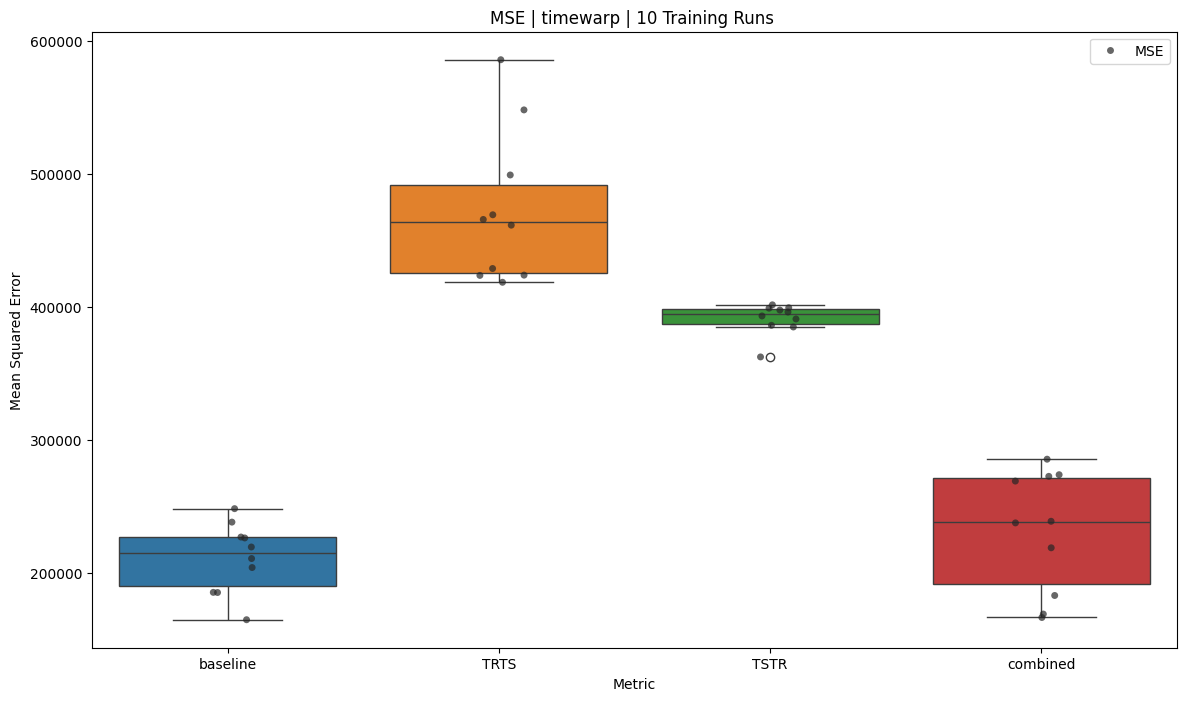

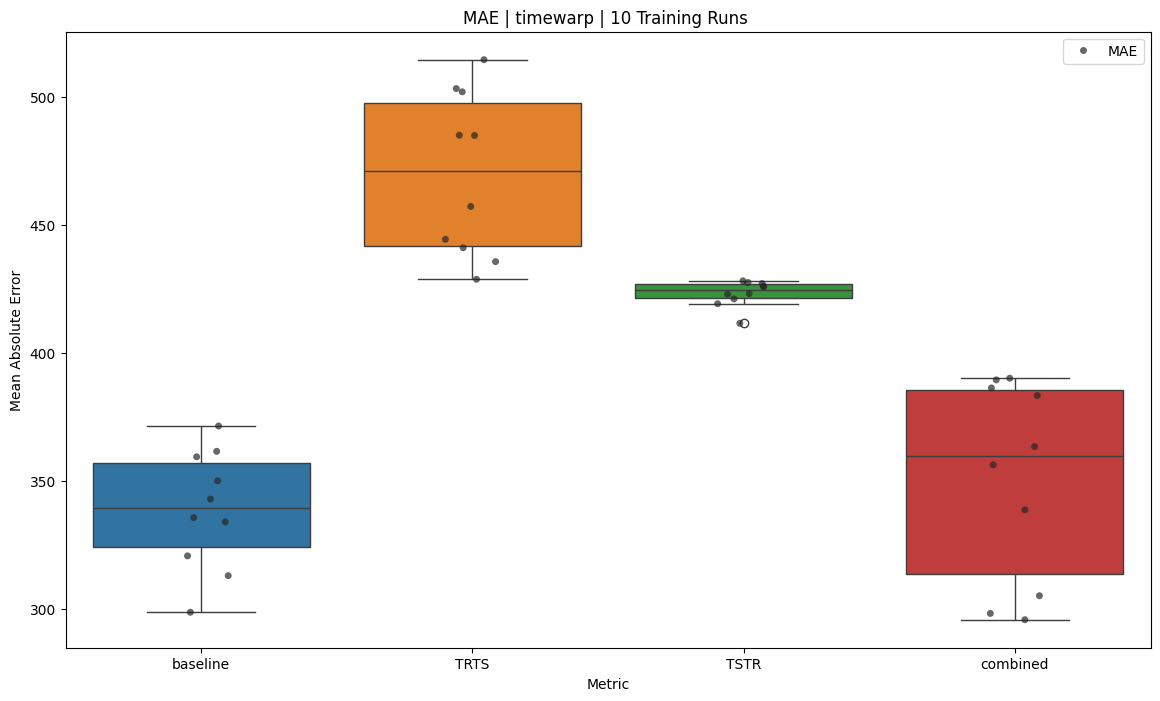

In [8]:
# plot results
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

In [9]:
0.2*1e06

200000.0